## Árvores de regressão - exercícios 02

Este exercício será uma continuação do anterior, mesma base, mesmas variáveis - vamos tentar buscar a 'melhor árvore'.


*Atenção - Utilizar a base de dados em anexo que é a mesma base que utilizamos na atividade anterior! A base Boston, assim como para a primeira atividade foi descontinuada e não deve ser utilizada*

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from IPython.display import display
from sklearn.metrics import r2_score

### 1. Execute os passos do exercício anterior, até que você tenha uma árvore de regressão predizendo o valor do imóvel na base de treinamento.

In [21]:
# 1) Carregar
df = pd.read_csv('housing.csv')

# 2) Pequenas features auxiliares
df['rooms_per_household']      = df['total_rooms']    / df['households']
df['bedrooms_per_room']        = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population']     / df['households']

# 3) One-hot para ocean_proximity
df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)

# 4) X, y
y = df['median_house_value']
X = df.drop(columns=['median_house_value'])

# 5) Split 60/20/20 (treino / validação / teste)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42)
X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=0.25, random_state=42)  # 0.25 de 0.80 = 0.20

print('Formas -> treino:', X_tr.shape, '| validação:', X_va.shape, '| teste:', X_te.shape)

Formas -> treino: (12384, 15) | validação: (4128, 15) | teste: (4128, 15)


In [22]:
# Árvore baseline SEM pré-poda
base_tree = DecisionTreeRegressor(random_state=42)
base_tree.fit(X_tr, y_tr)

# Caminho de poda via CCP
path = base_tree.cost_complexity_pruning_path(X_tr, y_tr)
ccp_alphas = path.ccp_alphas

print('Qtd de alphas:', len(ccp_alphas), '| primeiros:', np.round(ccp_alphas[:5], 6))


Qtd de alphas: 11151 | primeiros: [0.0e+00 4.0e-05 4.0e-05 5.4e-05 5.4e-05]


In [23]:
# ccp_alphas deve vir de cost_complexity_pruning_path(...)
# Remova o último (colapsa a árvore) e pegue valores únicos
alphas_full = np.unique(ccp_alphas[:-1])

# Se ainda tiver muitos, amostre 50 quantis ao longo do caminho
if len(alphas_full) > 50:
    alphas = np.quantile(alphas_full, np.linspace(0, 1, 50))
    alphas = np.unique(alphas)  # garante sem duplicatas
else:
    alphas = alphas_full

print(f"Total de alphas no caminho: {len(ccp_alphas)} | Avaliando: {len(alphas)}")


Total de alphas no caminho: 11151 | Avaliando: 50


In [24]:
# ccp_alphas deve vir de cost_complexity_pruning_path(...)
alphas_full = np.unique(ccp_alphas[:-1])

# Se ainda tiver muitos, amostre 50 quantis ao longo do caminho
if len(alphas_full) > 50:
    alphas = np.quantile(alphas_full, np.linspace(0, 1, 50))
    alphas = np.unique(alphas)  # garante sem duplicatas
else:
    alphas = alphas_full

print(f"Total de alphas no caminho: {len(ccp_alphas)} | Avaliando: {len(alphas)}")


Total de alphas no caminho: 11151 | Avaliando: 50


In [25]:
models, report = [], []

for i, a in enumerate(alphas, 1):
    model = DecisionTreeRegressor(random_state=42, ccp_alpha=a)
    model.fit(X_tr, y_tr)

    y_tr_pred = model.predict(X_tr)
    y_va_pred = model.predict(X_va)

    report.append({
        'ccp_alpha': a,
        'depth':     model.get_depth(),
        'n_leaves':  model.get_n_leaves(),
        'mse_train': mse(y_tr, y_tr_pred),
        'mse_val':   mse(y_va, y_va_pred),
    })
    models.append(model)

    # feedback a cada 5 modelos
    if i % 5 == 0 or i == len(alphas):
        print(f"Treinados {i}/{len(alphas)} modelos...")

rep = pd.DataFrame(report)
rep_sorted = rep.sort_values('mse_val')

display(rep_sorted.head(10))  # <<< mostra os melhores
best = rep_sorted.iloc[0]
print(f"Melhor alpha: {best.ccp_alpha:.6g} | MSE_val: {best.mse_val:,.0f} | "
      f"depth: {best.depth} | leaves: {best.n_leaves}")


Treinados 5/50 modelos...
Treinados 10/50 modelos...
Treinados 15/50 modelos...
Treinados 20/50 modelos...
Treinados 25/50 modelos...
Treinados 30/50 modelos...
Treinados 35/50 modelos...
Treinados 40/50 modelos...
Treinados 45/50 modelos...
Treinados 50/50 modelos...


,ccp_alpha,depth,n_leaves,mse_train,mse_val
48,4.689699e+06,17,202,2.367941e+09,3.793422e+09
47,2.415257e+06,21,414,1.662878e+09,4.120491e+09
46,1.572170e+06,24,616,1.267702e+09,4.311165e+09
45,1.111346e+06,24,806,1.017492e+09,4.448851e+09
44,8.556194e+05,24,995,8.314940e+08,4.583548e+09
43,6.870974e+05,25,1180,6.893751e+08,4.666805e+09
42,5.590183e+05,26,1363,5.755972e+08,4.762066e+09
41,4.544175e+05,27,1537,4.880028e+08,4.825759e+09
40,3.739321e+05,27,1711,4.169107e+08,4.897007e+09
39,3.102560e+05,28,1878,3.600648e+08,4.908110e+09


Melhor alpha: 4.6897e+06 | MSE_val: 3,793,422,277 | depth: 17.0 | leaves: 202.0


### 2.  Calcule o caminho indicado pelos CCP-alfas dessa árvore.

In [26]:
# 2.1) Obter o caminho bruto de alphas a partir SOMENTE do treino
path = DecisionTreeRegressor(random_state=42).cost_complexity_pruning_path(X_tr, y_tr)
raw_alphas = np.unique(path.ccp_alphas)

# 2.2) Limpezas simples: manter apenas > 0 e limitar cauda alta (opcional, deixa a grade mais estável)
pos = raw_alphas[raw_alphas > 0]
hi_cap = np.percentile(pos, 99.5)        # corta outliers muito altos
pos = pos[pos <= hi_cap]

# 2.3) Criar grade final de alphas (até 50 pontos, em escala log, cobrindo o intervalo observado)
n_max = 50
lo, hi = pos.min(), pos.max()
ccp_alphas = np.unique(np.geomspace(lo, hi, num=min(n_max, len(pos))))

# 2.4) Relato rápido
print(f'Alphas brutos: {len(raw_alphas)} | após filtro: {len(pos)} | grade usada: {len(ccp_alphas)}')
print('Exemplo de alphas:', np.round(ccp_alphas[:5], 6), '... ->', np.round(ccp_alphas[-5:], 6))

Alphas brutos: 7351 | após filtro: 7313 | grade usada: 50
Exemplo de alphas: [4.00e-05 7.00e-05 1.20e-04 2.08e-04 3.59e-04] ... -> [ 1922575.072911  3320222.431272  5733912.370159  9902273.642571
 17100893.240481]


### 3. Paca cada valor de alpha obtido no item 2, treine uma árvore com o respectivo alfa, e guarde essa árvore em uma lista.

In [27]:
models = []
report = []

for i, a in enumerate(ccp_alphas, start=1):
    # modelo com poda por custo-complexidade
    model = DecisionTreeRegressor(random_state=42, ccp_alpha=a)
    model.fit(X_tr, y_tr)

    # previsões
    ytr_pred = model.predict(X_tr)
    yva_pred = model.predict(X_va)

    # métricas e estrutura
    report.append({
        'ccp_alpha': a,
        'depth':     model.get_depth(),
        'n_leaves':  model.get_n_leaves(),
        'mse_train': mse(y_tr, ytr_pred),
        'mse_val':   mse(y_va, yva_pred),
    })
    models.append(model)

    if i % 10 == 0 or i == len(ccp_alphas):
        print(f'Treinados {i}/{len(ccp_alphas)} modelos...')

# DataFrame ordenado pelo desempenho em validação
rep = pd.DataFrame(report)
rep_sorted = rep.sort_values('mse_val', ascending=True).reset_index(drop=True)
display(rep_sorted.head(10))

# Guardar o melhor alpha/modelo (menor MSE em validação) para os próximos itens
best_idx   = rep_sorted['mse_val'].idxmin()
best_alpha = rep_sorted.loc[best_idx, 'ccp_alpha']
best_model = models[best_idx]

print(f'\nMelhor alpha: {best_alpha:.6g} | '
      f"MSE_val: {rep_sorted.loc[best_idx, 'mse_val']:.0f} | "
      f"depth: {rep_sorted.loc[best_idx, 'depth']} | "
      f"leaves: {rep_sorted.loc[best_idx, 'n_leaves']}")

Treinados 10/50 modelos...
Treinados 20/50 modelos...
Treinados 30/50 modelos...
Treinados 40/50 modelos...
Treinados 50/50 modelos...


,ccp_alpha,depth,n_leaves,mse_train,mse_val
0,5.733912e+06,17,160,2.587223e+09,3.727848e+09
1,9.902274e+06,12,81,3.152508e+09,3.866403e+09
2,3.320222e+06,19,297,1.987524e+09,3.938764e+09
3,1.710089e+07,10,43,3.611452e+09,3.986767e+09
4,1.922575e+06,24,523,1.429119e+09,4.231196e+09
5,1.113267e+06,24,805,1.018605e+09,4.449522e+09
6,6.446375e+05,25,1237,6.513958e+08,4.682742e+09
7,3.732774e+05,27,1712,4.165368e+08,4.896741e+09
8,2.161463e+05,28,2250,2.635664e+08,5.002427e+09
9,1.251595e+05,30,2906,1.539301e+08,5.091005e+09



Melhor alpha: 5.73391e+06 | MSE_val: 3727847592 | depth: 17 | leaves: 160


### 4. Para cada árvore na lista, calcule o MSE da árvore.

In [28]:
# Monta DataFrame a partir do relatório do item 3 e acrescenta o MSE de teste
rep_df = pd.DataFrame(report)  # 'report' foi preenchido no item 3
rep_df['mse_test'] = [mse(y_te, m.predict(X_te)) for m in models]

# Ordena pelos menores erros de validação
rep_sorted = rep_df.sort_values('mse_val').reset_index(drop=True)

# Mostra os 10 melhores alphas
display(rep_sorted.head(10))

# Pega o melhor alpha e o respectivo modelo
best = rep_sorted.iloc[0]
best_idx = rep_df.index[rep_df['ccp_alpha'] == best['ccp_alpha']][0]
best_model = models[best_idx]

print(
    f"Melhor alpha: {best['ccp_alpha']:.4g} | "
    f"MSE_val: {best['mse_val']:.0f} | "
    f"MSE_test: {best['mse_test']:.0f} | "
    f"depth: {best['depth']} | leaves: {best['n_leaves']}"
)

,ccp_alpha,depth,n_leaves,mse_train,mse_val,mse_test
0,5.733912e+06,17,160,2.587223e+09,3.727848e+09,3.722849e+09
1,9.902274e+06,12,81,3.152508e+09,3.866403e+09,3.918383e+09
2,3.320222e+06,19,297,1.987524e+09,3.938764e+09,3.946926e+09
3,1.710089e+07,10,43,3.611452e+09,3.986767e+09,4.069675e+09
4,1.922575e+06,24,523,1.429119e+09,4.231196e+09,4.297701e+09
5,1.113267e+06,24,805,1.018605e+09,4.449522e+09,4.491504e+09
6,6.446375e+05,25,1237,6.513958e+08,4.682742e+09,4.748232e+09
7,3.732774e+05,27,1712,4.165368e+08,4.896741e+09,4.807958e+09
8,2.161463e+05,28,2250,2.635664e+08,5.002427e+09,4.932193e+09
9,1.251595e+05,30,2906,1.539301e+08,5.091005e+09,5.028881e+09


Melhor alpha: 5.734e+06 | MSE_val: 3727847592 | MSE_test: 3722848902 | depth: 17.0 | leaves: 160.0


### 5. Monte um gráfico do MSE pelo alpha, escolha um valor de alpha perto do ponto de mínimo do MSE

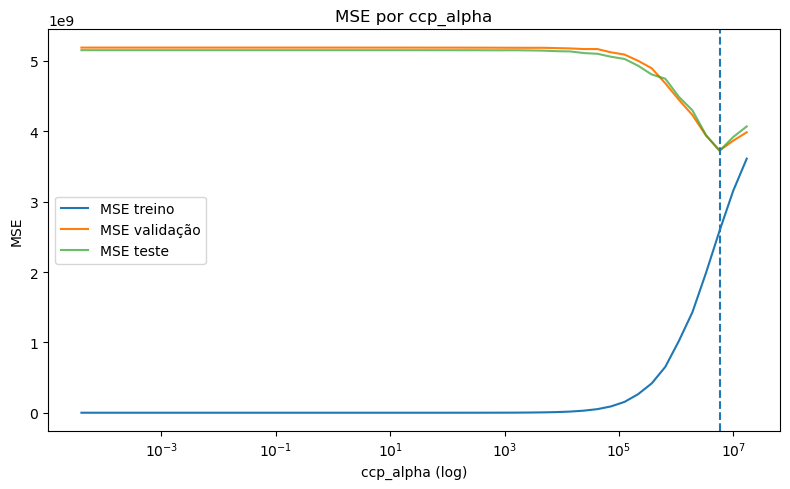

Alpha escolhido (perto do mínimo): 5.73391e+06


DecisionTreeRegressor(ccp_alpha=5733912.370158684, random_state=42)

In [29]:
# Ordena por alpha para plotar curvas suaves
plot_df = rep_df.sort_values('ccp_alpha').reset_index(drop=True)

plt.figure(figsize=(8,5))
plt.plot(plot_df['ccp_alpha'], plot_df['mse_train'], label='MSE treino')
plt.plot(plot_df['ccp_alpha'], plot_df['mse_val'],   label='MSE validação')
plt.plot(plot_df['ccp_alpha'], plot_df['mse_test'],  label='MSE teste', alpha=0.7)

plt.xscale('log')
plt.xlabel('ccp_alpha (log)')
plt.ylabel('MSE')
plt.title('MSE por ccp_alpha')
plt.legend()
plt.tight_layout()

# Escolha do alpha: mínimo em validação
alpha_star = rep_df.loc[rep_df['mse_val'].idxmin(), 'ccp_alpha']

# Linha vertical no alpha escolhido
plt.axvline(alpha_star, linestyle='--')
plt.show()

print(f"Alpha escolhido (perto do mínimo): {alpha_star:.6g}")

# (Opcional) treinar de novo o modelo final neste alpha, para uso no item 6
final_tree = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha_star)
final_tree.fit(X_tr, y_tr)


### 6. Calcule o R-quadrado dessa árvore encontrada no item acima

In [31]:
from sklearn.metrics import r2_score

# Predições
y_tr_hat = final_tree.predict(X_tr)
y_va_hat = final_tree.predict(X_va)
y_te_hat = final_tree.predict(X_te)

# R-quadrado por partição
r2_tr = r2_score(y_tr, y_tr_hat)
r2_va = r2_score(y_va, y_va_hat)
r2_te = r2_score(y_te, y_te_hat)

print(f"R² treino      : {r2_tr:.4f}")
print(f"R² validação   : {r2_va:.4f}")
print(f"R² teste       : {r2_te:.4f}")


R² treino      : 0.8047
R² validação   : 0.7285
R² teste       : 0.7159


### 7. Visualize esta árvore.

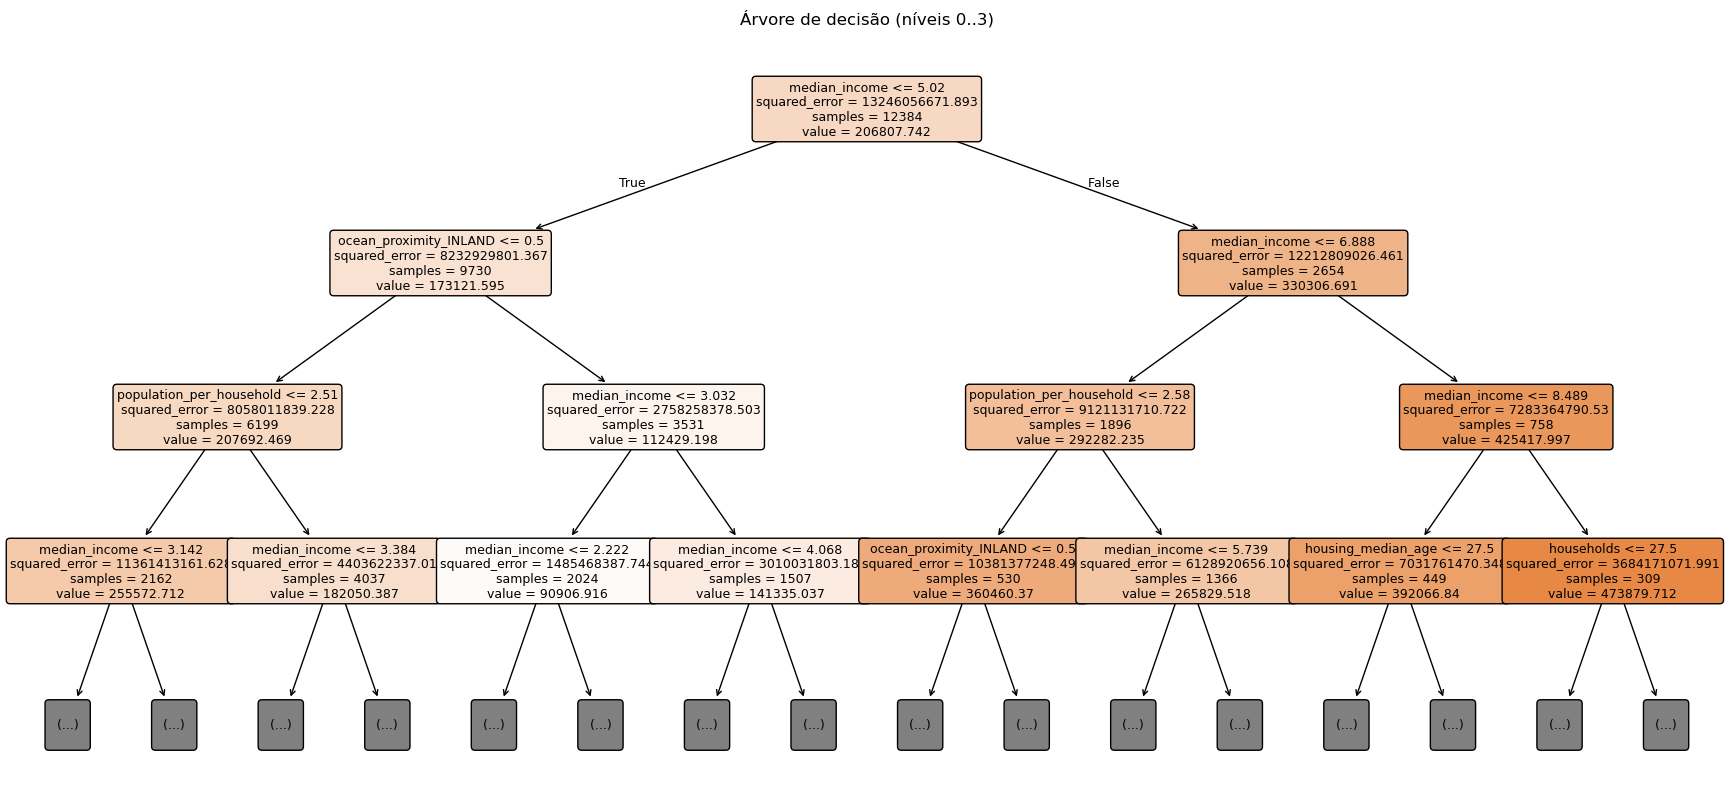

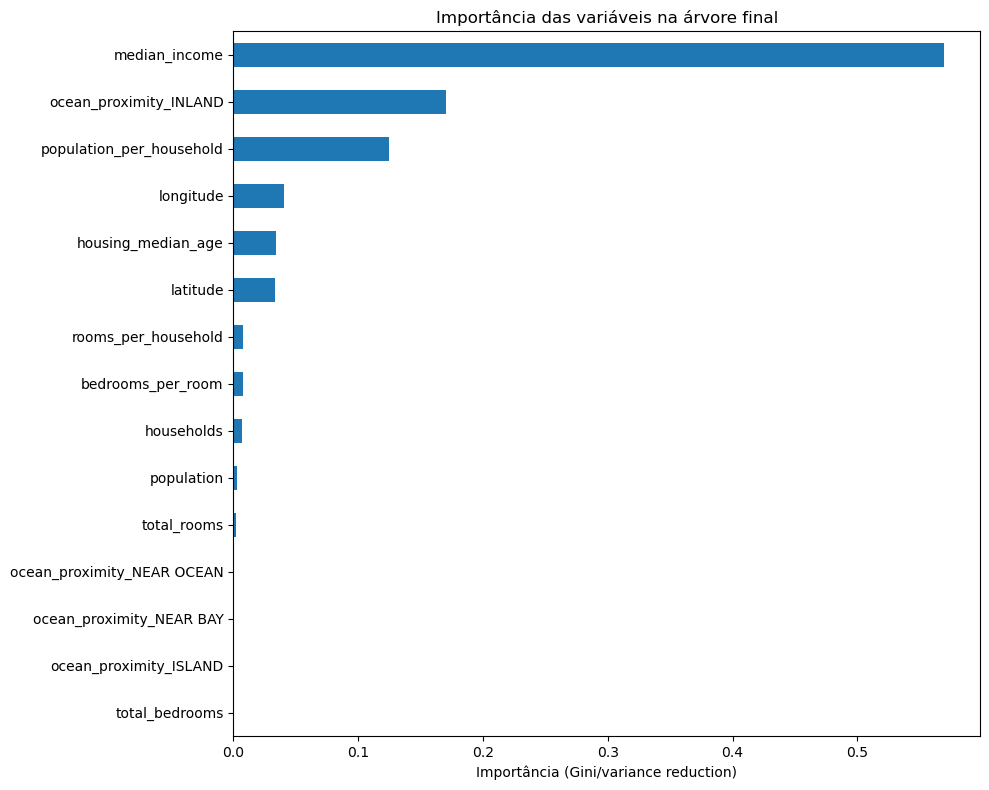

In [37]:
# 7.1 Árvore (apenas os 3 primeiros níveis para leitura clara)
plt.figure(figsize=(22, 10))
tree.plot_tree(
    final_tree,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    max_depth=3,      # mostra níveis 0..3
    fontsize=9
)
plt.title("Árvore de decisão (níveis 0..3)")
plt.show()


# 7.3 Importância das variáveis
imp = pd.Series(final_tree.feature_importances_, index=X.columns)\
       .sort_values(ascending=True)

plt.figure(figsize=(10, 8))
imp.plot(kind="barh")
plt.xlabel("Importância (Gini/variance reduction)")
plt.title("Importância das variáveis na árvore final")
plt.tight_layout()
plt.show()